<h6>Assignment 2 |
    <i>GEOG5995M - 201189627</i></h6>
<h1>Tracking  A Biological Weapon Fallout</h1>



This Jupyter notebook describes the steps of delevopment of a model to estimate the spread of bacteria from biological bomb. It is assumed that the bomb has been activated on the top of a building and wind is the only element affecting the dispersion of the particles. The output of this simulation is an estimated concentration of bacteria at ground level. In the final section, an interactive version of the model is presented.

<div class="alert alert-warning" markdown="1">
  <p><i><strong>IMPORTANT!!!</strong> To run the interactive SECTION, this notebook has to be downloaded in a local machine. Python 3.7 and the dependencies below must be installed. Finally, open the file using Jupyter Notebooks or equivalent</i><p>
</div>


In [82]:
from IPython.core.display import HTML
HTML("""
<style>
h1, .h1 {
    font-family: "Segoe UI";
    font-size: 5em !important;
    color: #2a7bbd;}
h2, .h2 {
    font-family: "Segoe UI";
    font-size: 2.3em !important;
    color: #165e99;}
h3, .h3 {
    font-family: "Segoe UI";
    font-size: 1.9em !important;
    color: #0e5691;}
h4, .h4 {
    font-family: "Segoe UI";
    font-size: 1.6em !important;
    color: #0a3c66;}
h5, .h5 {
    font-family: "Segoe UI";
    font-size: 1.3em !important;
    color: #053358;}
p, .p {font-size: 12px;
    font-family: "Segoe UI";
    font-size: 1em;
    color: #000000;}
</style>
""")

In [1]:
import random
import csv
import matplotlib.pyplot
import requests
import codecs
# Modules for interactive section
import time
import ipywidgets

As the code uses some randomisation, the following line of code can be run to produce consistent results for testing purposes

In [2]:
# random.seed(1)

### Bomb drop location
The first step is to determine the drop location using the data provided in a 300x300 raster file. The following blocks of code read the raster and show the point where biological bomb start the spread of particles.

In [3]:
bomb_location = []
#This line silences a warning linked to the certificate of the original URL
requests.packages.urllib3.disable_warnings(
    requests.packages.urllib3.exceptions.InsecureRequestWarning)
res = requests.get("https://www.geog.leeds.ac.uk/courses/\
computing/study/core-python-phd/assessment2/wind.raster", verify = False)

In [4]:
lines_iterator = res.iter_lines()
# create a CSV reader object and encode the content using the codecs module
data = csv.reader(codecs.iterdecode(lines_iterator, encoding="utf-8"), delimiter=",")
# loop through the rows on the "data" list
for index, row in enumerate(data):
    # Initialise the rowist
            rowlist = []
            # Loop for the values
            for value in row:
                rowlist.append(int(value))
            bomb_location.append(rowlist)

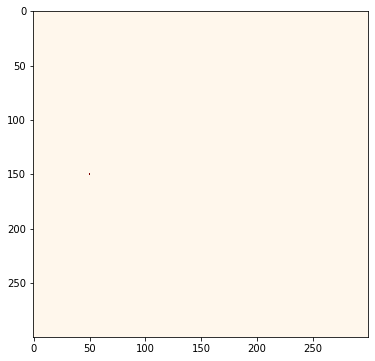

In [5]:
matplotlib.pyplot.figure(figsize = (6,6))
matplotlib.pyplot.imshow(bomb_location, cmap='OrRd', aspect='auto')

The coordinates of the drop point are extracted using the code below and stored in ```x0``` and ```y0```.

In [6]:
for i, row in enumerate(bomb_location):
    for j, value in enumerate(row):
        if (value==255):
            x0=j
            y0=i
            break
    if (value==255):
        break
print("Drop point coordinates---> x:",x0," y:",y0)

Drop point coordinates---> x: 50  y: 150


## Static Model
### Particles
To recreate the movement of a particle/bacteria from the top of the building to the ground, a class with three properties was defined. The properties are the position of the particle/bateria on each axis (units in metres), i.e. ```x``` represents the West-East position, ```y``` represents the North-South position and ```z``` the height measured from the ground. The ```x-y``` origin is consistent with the coordinates of the raster file which contained the drop point coordinates.

In [7]:
class Particle():
    def __init__ (self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
    
    @property
    def x (self):
        return (self._x)
    
    @property
    def y (self):
        return (self._y)
    
    @property
    def z (self):
        return (self._z)
    
    @x.setter
    def x (self,n):
        self._x=n
      
    @y.setter
    def y (self,n):
        self._y=n
        
    @z.setter
    def z (self,n):
        self._z=n

### Particle movement


Each particle will change its coordinates (i.e. move) maximum by 1 metre following a set of simple rules which use pre-defined proabilities. The movement in the space (3D) is split into horizontal or planar (```x-y```), and vertical (```z```) movements. 

For the ```xy``` movement the propabilities are:
- 5% chance of blowing west,
- 10% chance of blowing north
- 10% chance of blowing south,
- and a 75% chance of blowing east.

For the vertical (```z```) movement the propabilities are:
- 20% chance of going up (elevating),
- 10% change of staying at the same level,
- and 70% of falling.

#### Sampling numbers from random distribution
It is important to ensure that the sampling function does not produce the wrong type of distribution which could result in an incorrect application of the probilities. A visual test was undertaken to check that the numbers between 0 and 1 which are generated by the ```random.uniform```. As shown in the plot below the function is suitable as it produces a distribution without any skewness:  

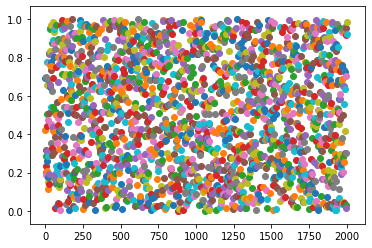

In [8]:
for i in range(2000):
    matplotlib.pyplot.scatter(i,random.uniform(0,1))

#### A function for the movement

The following function was defined to recreate the movement of a particle/bacteria in any given second. It takes two arguments as inputs: the current particle and a list with the probabilities. Default values for the probabilities have been assigned based on values shown before.

In [9]:
def move(Particle, prob2D = [0.05,0.75,0.1,0.1]):
    randxy = random.uniform(0,1)
    #print("xy",randxy)
    randz = random.uniform(0,1)
    #print("z",randz)

    #Planar/horizonal movement
    if randxy <= sum(prob2D[0:1]):
        Particle.x = Particle.x - 1 # Move to the East
    if sum(prob2D[0:1]) < randxy <= sum(prob2D[0:2]):
        Particle.x = Particle.x + 1 # Move to the West
    if  sum(prob2D[0:2]) < randxy <= sum(prob2D[0:3]):
        Particle.y = Particle.y - 1 # Move to the South
    if sum(prob2D[0:3]) < randxy <= sum(prob2D[0:4]):
        Particle.y = Particle.y + 1 # Move to the North

    # Vertical movement
    if randz <= 0.2:
        Particle.z = Particle.z + 1 # Move up
    if 0.2 < randz <= 0.90:
        Particle.z = Particle.z - 1 # Move down

The following code shows an example of the movement of a particle with initial coordinates ```x = 20```,```y = 50```, and ```z = 30```.

In [10]:
particle1=Particle(x = 20, y = 50, z = 30)
print("Initial coordinates----> x:",particle1.x," y:", particle1.y," z:",particle1.z)
move(particle1)
print("Final coordinates  ----> x:",particle1.x," y:", particle1.y," z:",particle1.z)

Initial coordinates----> x: 20  y: 50  z: 30
Final coordinates  ----> x: 21  y: 50  z: 29


#### Full movement of a particle to the ground
Now that we have a class for the particles and a function to recreate the movement, it is possible to simulate the full trajectory of a single particle from the top of the building where the biological bomb was  set off.

Assuming that the height of the bulding is 75 m, every particle/bacteria in the bomb will start with the same coordinates. The definition of any  ```particle```'s  initial conditions (t<sub>0</sub>) will be:

In [11]:
particle = Particle(x = x0, y = y0, z = 75)

##### Control Statement
We are interested in the final ```xy``` coordinates of all particles when they touch the ground. For this purpose, a ```while``` loop can be defined to apply the ```move``` function until the particle ```z``` coordinate is ```0```.

In [12]:
while particle.z>0 :
    move(particle)
    # print(particle.x,particle.y,particle.z)

print(particle.x,particle.y,particle.z)

182 154 0


However, the previous definition of the loop might result in an error if a particle moves outside the boundaires of the defined space. Two apporaches can be used in that case, expand the area as required or ignore the particles that move out of the 300x300 square. The latter was used for this exercise adding an ```if``` statement to validate the ```x``` and ```y``` coordinates.

In [13]:
while particle.z>0 :
    particle.move()
    # Apply boundary restrictions, if met the while loop stops
    if not(particle.x in range(len(bomb_location[0]))) or not(particle.y in range(len(bomb_location))):
        break

[74, 75, 74, 75, 74, 73, 72, 73, 74, 75, 74, 73, 72, 71, 70, 69, 69, 68, 67, 66, 65, 64, 63, 62, 61, 62, 63, 64, 64, 65, 64, 63, 62, 61, 60, 60, 61, 60, 59, 60, 61, 60, 59, 59, 60, 61, 60, 59, 60, 59, 58, 58, 57, 56, 55, 56, 57, 56, 55, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 46, 45, 44, 44, 44, 45, 44, 43, 42, 43, 42, 43, 44, 43, 42, 41, 40, 40, 40, 39, 38, 37, 36, 35, 35, 34, 33, 32, 33, 32, 31, 31, 30, 30, 31, 30, 30, 29, 28, 29, 28, 27, 26, 25, 24, 23, 22, 22, 21, 20, 19, 18, 17, 16, 15, 14, 15, 15, 14, 13, 12, 11, 10, 9, 8, 8, 7, 6, 5, 4, 3, 4, 5, 4, 3, 2, 3, 2, 1, 0]


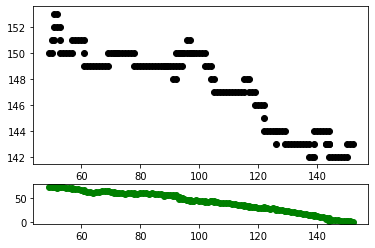

In [14]:
particle = Particle(x = x0, y = y0, z = 75)
part_path_x=[]
part_path_y=[]
part_path_z=[]
while particle.z>0 :
    move(particle)
    part_path_x.append(particle.x)
    part_path_y.append(particle.y)
    part_path_z.append(particle.z)
    # Apply boundary restrictions, if met the while loop stops
    if not(particle.x in range(len(bomb_location[0]))) or not(particle.y in range(len(bomb_location))):
        break

# define subplots
fig, ax = matplotlib.pyplot.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]},)


print(part_path_z)

# create subplots
ax[0].scatter(part_path_x, part_path_y, color='black')
ax[1].scatter(part_path_x, part_path_z, color='green')
# display the plot
matplotlib.pyplot.show()



### A clear ground
The following function creates an object to represent the ground and to store the particle density, namely, the number of particles that touched the ground in each coordinate. The size of the ground is consistent with the original input file (300x300)

In [15]:
def clear_ground():
    ground=[]
    for i in range(len(bomb_location)):
        tmp_row = []
        for j in range(len(bomb_location[0])):
            tmp_row.append(0)
        ground.append(tmp_row)
    return(ground)
# Produce the clear ground object
myground = clear_ground()

### All particles
All the elements are put into a ```for``` loop that simulates the full movement of each particle for a total of 5000 particles.

In [16]:
# Define the number of particles
n_particles = 5000
# Run simulation with n_particles
for i in range(n_particles):
    # Initial conditions
    particle = Particle(x = x0, y = y0, z = 75)
    
    # Movement until it reaches the gound
    while particle.z>0 :
        move(particle)
        if not(particle.x in range(len(myground[0])-1)) or not(particle.y in range(len(myground)-1)):
            break
    
    # Update the ground density object  
    if particle.z==0:
        myground[particle.y][particle.x] += 1

The following lines produce a plot with the resulting density. The drop point is annotated with black **```+```**

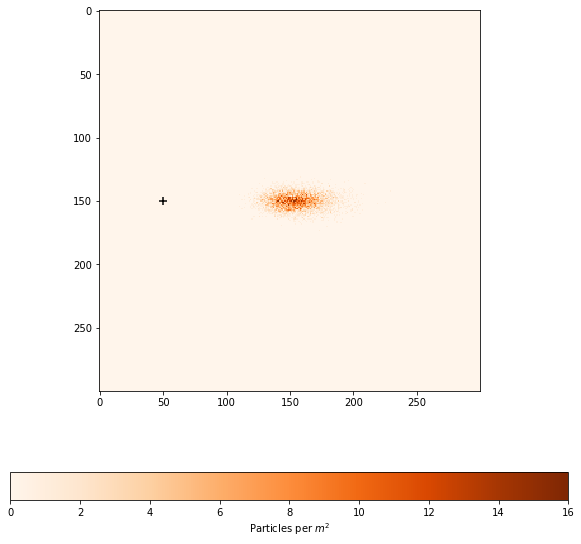

In [17]:
matplotlib.pyplot.figure(figsize = (10,10))
matplotlib.pyplot.imshow(myground, cmap='Oranges')
matplotlib.pyplot.colorbar(label=r'Particles per '+'$m^2$', orientation="horizontal")
matplotlib.pyplot.scatter(x0, y0, s = 50, c = 'black', marker = "+") # Drop point
matplotlib.pyplot.show()

Finally, a ```txt``` file is written in the folder where this Jupyter notebook is saved. The name of the file will contain the parameters of the simulation such as the number of particles, height of the building and wind-based probabilities. As an example, the results of the simulation above are saved as ```FinalGround_P5000_h75_E5_W75_S10_N10.txt```

In [18]:
def final_ground(n_particles,height,Ew = 0.05, Ww = 0.7, Nw = 0.1, Sw = 0.1):
    # Save the ground density
    f = open("FinalGround"+
             "_P"+str(n_particles)+
             "_H"+str(height)+
             "_E"+str(int(100*Ew))+
             "_W"+str(int(100*Ww))+
             "_N"+str(int(100*Nw))+
             "_S"+str(int(100*Sw))+
             ".txt", 'w+',   newline = "")
    with f:
        write = csv.writer(f) 
        write.writerows(myground)
    f.close()
final_ground(n_particles,height = 75,Ew = 0.05, Ww = 0.7, Nw = 0.1, Sw = 0.1)

***
## Interactive model 
This section includes an interactive version of the model that allows the user to specify customised parameters for:
- Number of particles
- Height of the building
- A set of wind-based probabilities for the horizontal movement

The inputs are captured using Sliders defined using the ```ipywidgets``` module. All sliders are initialised with the default values of the run shown before.

In [19]:
# Definition of all sliders for interactive inputs
# Number of Particles
part_slider = ipywidgets.IntSlider(value=5000, min=1, max=10000, step=1, description='Particles (N):', readout=True)
# Height of the building
h_slider = ipywidgets.IntSlider(value=75, min=1, max=100, step=1, description='Height (m):', readout=True)

# Wind direction Probabilities
W_widget = ipywidgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.05,description='Probability W:')
E_widget = ipywidgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.75,description='Probability E:')
N_widget = ipywidgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.10,description='Probability N:')
S_widget = ipywidgets.FloatSlider(min=0.01, max=1, step=0.01, value=0.10,description='Probability S:')

As the values of the probabilities should add up to 1, the user inputs are normalised after clicking the button. 

In [20]:
def normProbs():
    # Normalise the values of the probabilities
    total = (W_widget.value+E_widget.value+N_widget.value+S_widget.value)
    W_widget.value = W_widget.value/total
    E_widget.value = E_widget.value/total
    N_widget.value = N_widget.value/total
    S_widget.value = S_widget.value/total

All functions that were defined previously (i.e. producing a clear ground raster, run simulation, visualisation and producing an output file) are compiled into a main function that is executed when clicking the ```Run Interact``` button. Additionally, the time required for all particles to touch the ground is displayed below the colour scale legend.

In [21]:
def run(n_particles,height,Ew,Ww,Nw,Sw):
    # Record start time for timing
    start = time.process_time()
    
    #Update values in sliders before using them
    normProbs()
    
    # Prepare Probability list for move method
    probabilities = [W_widget.value,E_widget.value,N_widget.value,S_widget.value]
    
    # Clean the ground raster
    myground = clear_ground()

    # Run main loop
    for i in range(n_particles):
        particle = Particle(x = x0, y = y0, z = height)

        max_its=0
        while particle.z>0 :
            move(particle,probabilities)
            if not(particle.x in range(len(myground[0])-1)) or not(particle.y in range(len(myground)-1)):
                break
            max_its=max_its+1

        if particle.z==0:
            myground[particle.y][particle.x] += 1
            

    # Visualisation
    matplotlib.pyplot.figure(figsize = (10,10))
    matplotlib.pyplot.imshow(myground, cmap='Oranges')
    matplotlib.pyplot.colorbar(label=r'Particles per '+'$m^2$', orientation="horizontal")
    matplotlib.pyplot.scatter(x0, y0, s = 50, c = 'black', marker = "+") # Drop point
    matplotlib.pyplot.show()
    
    # Write the output file 
    final_ground(n_particles, height,Ew, Ww, Nw, Sw)
    # Record end time for timing
    end = time.process_time()
    
    # Show the elapsed time (for all particles to reach the ground)
    return("All particles touch the ground after "+str(max_its)+" s (Model Runtime "+str(end - start)+" s)")
    

In [22]:
# Set up for the UI with slides and links values to values for the run function
ipywidgets.interact_manual(run,
                        n_particles = part_slider,
                        height = h_slider,
                        Ew = E_widget, Ww = W_widget, Nw = N_widget, Sw = S_widget
                       )

interactive(children=(IntSlider(value=5000, description='Particles (N):', max=10000, min=1), IntSlider(value=7…

<function __main__.run(n_particles, height, Ew, Ww, Nw, Sw)>